In [143]:
import sys
sys.path.append("..")

In [144]:
import numpy as np
import gmsh
import meshio
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML
import scipy.interpolate
import scipy.sparse

from femns2d import femns2d

In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [146]:
def create_unit_square_mesh(name="unit_square.msh"):
    gmsh.initialize()
    gmsh.model.add('unit_square')
    
    pfactor = 1.0
    # Create points for unit square corners
    gmsh.model.geo.addPoint(0, -1, 0, pfactor, 1)
    gmsh.model.geo.addPoint(5, -1, 0, pfactor, 2)
    gmsh.model.geo.addPoint(5, 1, 0, pfactor, 3)
    gmsh.model.geo.addPoint(0, 1, 0, pfactor, 4)

    # Connect points with lines to form unit square
    gmsh.model.geo.addLine(1, 2, 1)
    gmsh.model.geo.addLine(2, 3, 2)
    gmsh.model.geo.addLine(3, 4, 3)
    gmsh.model.geo.addLine(4, 1, 4)

    # Create Curve Loop and Plane Surface
    gmsh.model.geo.addCurveLoop([1, 2, 3, 4], 1)
    gmsh.model.geo.addPlaneSurface([1], 1)

    # Add physical lines for the boundaries
    gmsh.model.geo.addPhysicalGroup(1, [1], 1)
    gmsh.model.geo.addPhysicalGroup(1, [2], 2)
    gmsh.model.geo.addPhysicalGroup(1, [3], 3)
    gmsh.model.geo.addPhysicalGroup(1, [4], 4)    
    # Add physical group for the surface
    gmsh.model.geo.addPhysicalGroup(2, [1], 5)

    # Synchronize model and define mesh size
    gmsh.model.geo.synchronize()

    # Generate 2D mesh
    gmsh.model.mesh.generate(2)

    # Save mesh
    gmsh.write('unit_square.msh')

    gmsh.finalize()

In [147]:
create_unit_square_mesh()

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.000427441s, CPU 0.000878s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.000626451s, CPU 0.000683s)
Info    : 21 nodes 44 elements
Info    : Writing 'unit_square.msh'...
Info    : Done writing 'unit_square.msh'


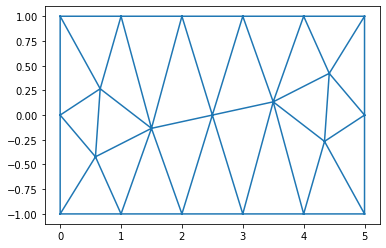

In [148]:
# Read the mesh file
mesh = meshio.read("unit_square.msh")

# Plot the mesh
fig, ax = plt.subplots()
ax.triplot(mesh.points[:, 0], mesh.points[:, 1], mesh.cells_dict["triangle"])

plt.show()

In [149]:
mesh = meshio.read("unit_square.msh")
points = mesh.points
elements = mesh.cells_dict["triangle"]
boundary_elements = mesh.cells_dict["line"]

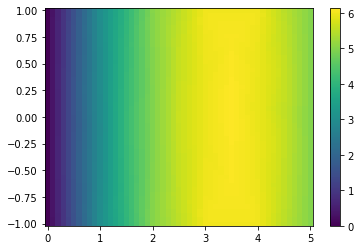

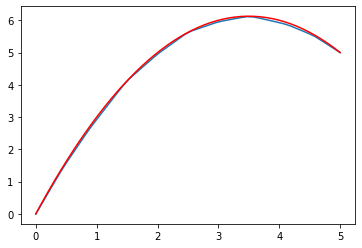

In [150]:
assembler = femns2d.MiniAssembler(mesh)
dirichlet_bcs_p = [[0, 5], [4, 2]]
Kp = assembler.stiffness_matrix()
Kp = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_p[1], Kp, 'u')
fp = assembler.forcing_vector(1.0)
fp = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_p, fp, 'u')
p = scipy.sparse.linalg.spsolve(Kp.tocsc(), fp)
p_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], p)
X, Y = np.meshgrid(np.linspace(0, 5, 51), np.linspace(-1, 1, 51))
P = p_interp(X, Y)
plt.figure()
plt.pcolormesh(X, Y, P, shading='auto')
plt.colorbar()
plt.figure()
n = 50
y = np.zeros(n)
x = np.linspace(0, 5, n)
p = p_interp(x, y)
plt.plot(x, p)
plt.plot(x, -1/2*x**2 + (5 + 25/2)/5*x, 'r')

In [152]:
# dirichlet_bcs_u = [[0, 0], [1, 3]]
# dirichlet_bcs_v = [[0, 0], [1, 3]]
# dirichlet_bcs_p = [[5, 0], [4, 2]]
assembler = femns2d.MiniAssembler(mesh)
Re = 1.0
ex = np.array([1.0, 0.0])
ey = np.array([0.0, 1.0])
body_force_x = 0.0
body_force_y = -1.0

K = assembler.stiffness_matrix(1/Re)
Azero = scipy.sparse.dok_matrix((assembler.npointse, assembler.npointse))
Azerop = scipy.sparse.dok_matrix((assembler.npoints, assembler.npoints))
Guxp = assembler.velocity_pressure_convection_matrix(ex)
Guyp = assembler.velocity_pressure_convection_matrix(ey)
Gpux = Guxp.T
Gpuy = Guyp.T
Au = scipy.sparse.bmat([[K, Azero, Guxp]])
Av = scipy.sparse.bmat([[Azero, K, Guyp]])
Ap = scipy.sparse.bmat([[Gpux, Gpuy, Azerop]])
A = scipy.sparse.bmat([[Au], [Av], [Ap]])
A = scipy.sparse.dok_matrix(A)
u_bc_func = lambda x : 1-(x[..., 1]**2)
u_bc_func = 1.0
dirichlet_bcs_u = [[0, 0], [1, 3]]
dirichlet_bcs_v = [[0, 0], [1, 3]]
dirichlet_bcs_p = [[5, 0], [4, 2]]

A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_p[1], A, 'p')
A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_u[1], A, 'u')
A = assembler.apply_dirichlet_to_matrix(dirichlet_bcs_v[1], A, 'v')
f = np.hstack([assembler.forcing_vector(0.0),
               assembler.forcing_vector(0.0),
               assembler.forcing_vector(0.0)[:assembler.npoints]])

f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_p, f, 'p')
f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_u, f, 'u')
f = assembler.apply_dirichlet_to_vector(*dirichlet_bcs_v, f, 'v')


In [164]:
Guxp

<47x21 sparse matrix of type '<class 'numpy.float64'>'
	with 181 stored elements in Dictionary Of Keys format>

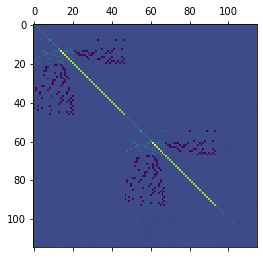

In [167]:
plt.matshow(A.toarray())

In [156]:
A_sparse = A.tocsc()
uxyp = scipy.sparse.linalg.spsolve(A_sparse, f)

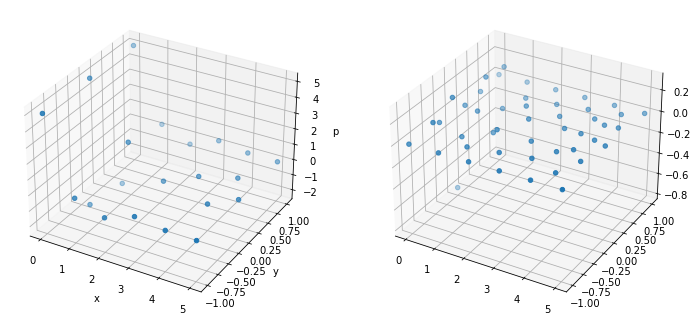

In [157]:
ux, uy, p = split_velocities(uxyp)
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(121, projection='3d')
xp, yp = assembler.points[:, 0], assembler.points[:, 1]
ax.scatter(xp, yp, p)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("p")
ax = fig.add_subplot(122, projection='3d')
xe, ye = assembler.pointse[:, 0], assembler.pointse[:, 1]
ue = np.sqrt(ux**2 + uy**2)
ax.scatter(xe, ye, ux)

In [158]:
p

array([ 5.        ,  0.        ,  0.        ,  5.        ,  0.28020352,
       -0.37788143,  0.29093038,  0.02473746,  0.        ,  0.03219033,
        0.29849365, -0.46373657,  0.3352008 ,  5.        ,  2.03348751,
        0.30014914, -0.2421252 , -2.0898635 ,  0.00728384, -1.83191298,
        0.00818791])

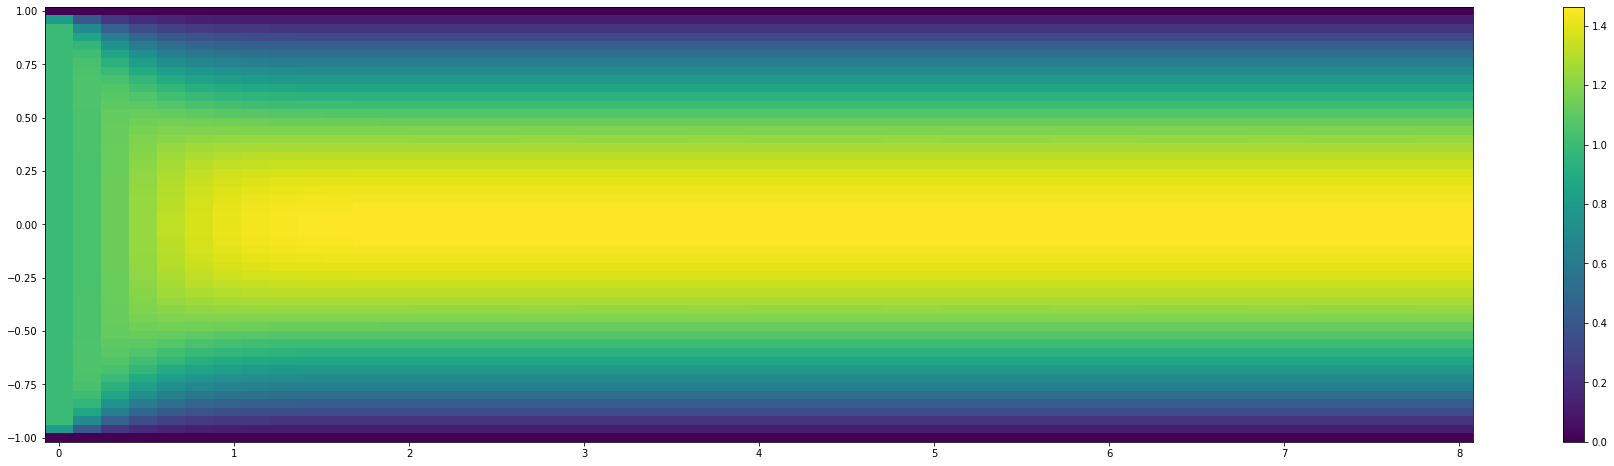

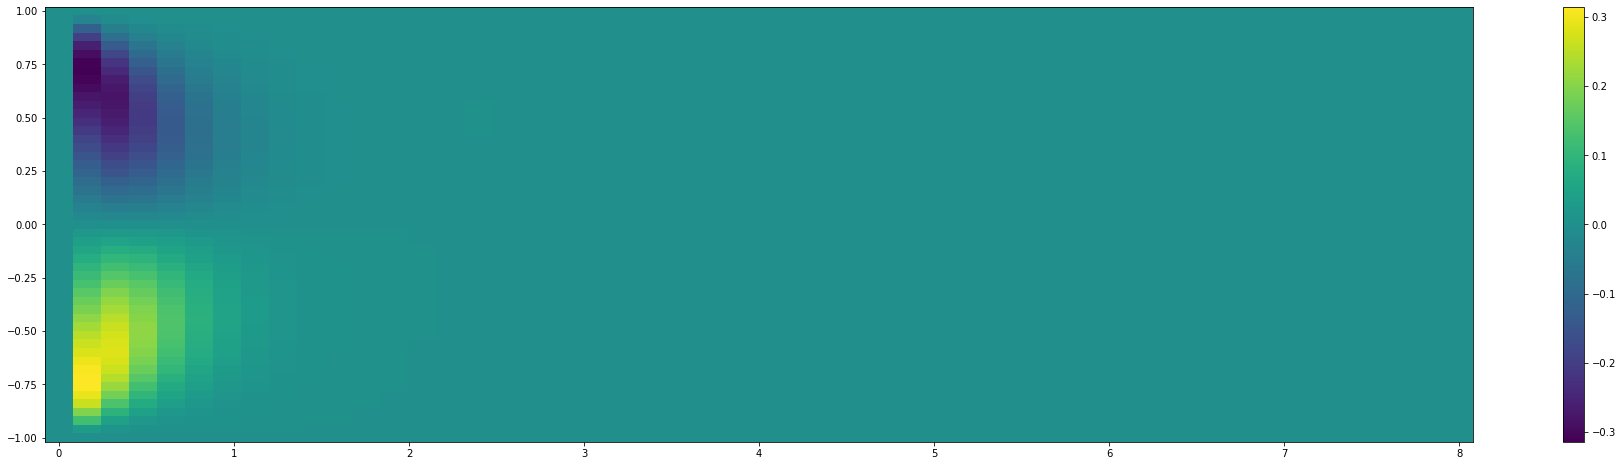

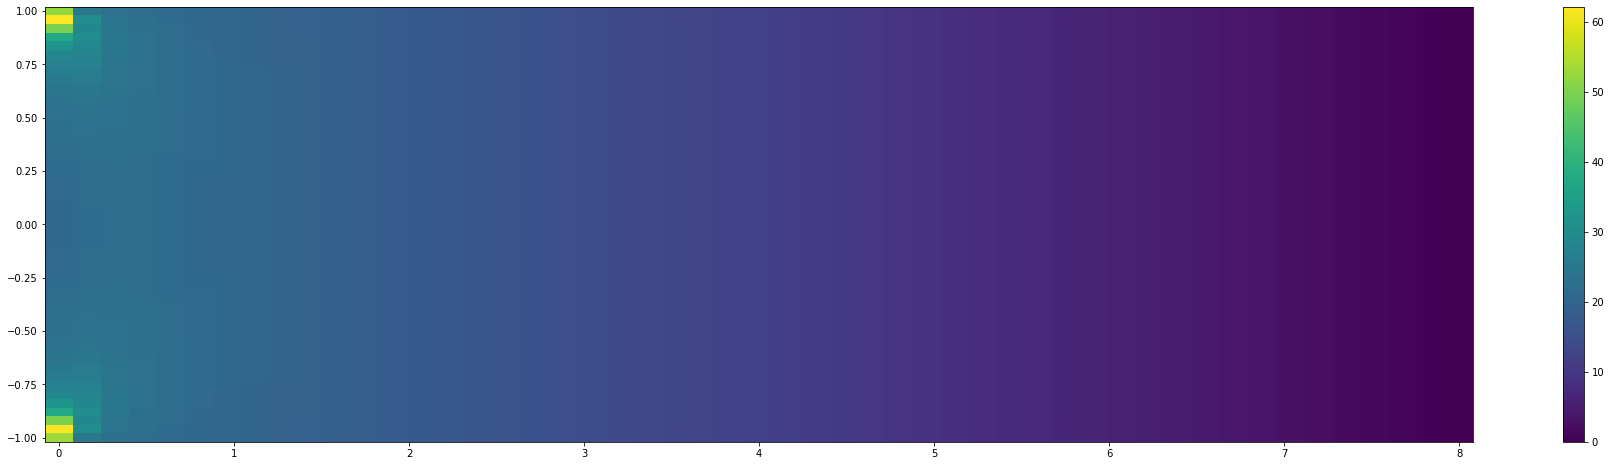

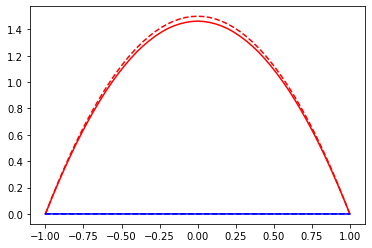

In [102]:
def split_velocities(uxyp):
    n = assembler.npoints + assembler.nelements
    ux = uxyp[..., :n]
    uy = uxyp[..., n:2*n]
    p = uxyp[..., 2*n:]
    return ux, uy, p
ux, uy, p = split_velocities(uxyp)
ux_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], ux)
uy_interp = scipy.interpolate.LinearNDInterpolator(assembler.pointse[:, :-1], uy)
p_interp = scipy.interpolate.LinearNDInterpolator(assembler.points[:, :-1], p)

X, Y = np.meshgrid(np.linspace(0, 8, 51), np.linspace(-1, 1, 51))
UX = ux_interp(X, Y)
UY = uy_interp(X, Y)
P = p_interp(X, Y)
for Z in [UX, UY, P]:
    plt.figure(figsize=(32, 8))
    plt.pcolormesh(X, Y, Z, shading='auto')
    plt.colorbar()

n = 51
x = np.ones(n)*8.0
y = np.linspace(-1, 1, n)
ux = ux_interp(x, y)
uy = uy_interp(x, y)

plt.figure()
plt.plot(y, ux, 'r')
plt.plot(y, uy, 'b')
plt.plot(y, 1.5*(1-y**2), 'r--')
plt.plot(y, 0.0*y, 'b--')